# Risk Premia Harvesting - Buy & Hold Strategy

## Overview

This notebook implements a simple buy-and-hold strategy to harvest risk premia from a diversified portfolio. The approach is straightforward: purchase assets at the beginning of the period and hold them for the entire duration (approximately 10 years) with no rebalancing required.

**Portfolio Composition:**
- SPY (S&P 500 ETF): 50%
- TLT (Long-term Treasury ETF): 35%
- GLD (Gold ETF): 15%

**Initial Capital:** $10,000.00

## Target Outputs

### Performance Metrics
- Annualized Return
- Annualized Volatility
- Sharpe Ratio
- Maximum Drawdown

### Visualizations
- Equity curves (total portfolio and individual assets)
- 1-year rolling annualized return
- 1-year rolling annualized volatility
- 1-year rolling Sharpe ratio

## Implementation Steps

### 1. Data Acquisition
Load historical price data for SPY, TLT, and GLD

### 2. Data Preparation
   1. Remove rows with missing data
   2. Ensure all tickers share the same date index

### 3. Portfolio Initialization
   1. Set initial capital and asset weights
   2. Select the first trading date
   3. Calculate dollar allocation per asset
   4. Determine the number of shares for each asset

### 4. Equity Curve Construction
   1. Calculate daily equity for each asset
   2. Compute total portfolio equity
   3. Consolidate results into a unified DataFrame

### 5. Returns Calculation
   1. Compute portfolio daily returns
   2. Compute individual asset daily returns

### 6. Performance Statistics
   1. Calculate annualized return
   2. Calculate annualized volatility
   3. Calculate Sharpe ratio
   4. Calculate maximum drawdown

### 7. Static Visualizations
Plot all equity curves on a single chart

### 8. Rolling Performance Analysis
   1. Generate rolling 1-year annualized return chart
   2. Generate rolling 1-year annualized volatility chart
   3. Generate rolling 1-year Sharpe ratio chart

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Data Acquisition

spy_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_SPY.csv", index_col=0, parse_dates=True)
tlt_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_TLT.csv", index_col=0, parse_dates=True)
gld_returns = pd.read_csv("C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\data\\returns\\returns_GLD.csv", index_col=0, parse_dates=True)

# 2. Data Preparation

# Combine all returns into a single DataFrame
close_df = pd.DataFrame({
    'SPY': spy_returns['Close'],
    'TLT': tlt_returns['Close'],
    'GLD': gld_returns['Close']
})

# Drop rows with any missing data
close_df = close_df.dropna()

In [2]:
# 3. Portfolio Initialization

# Set initial capital and asset weights
initial_capital = 10000.00
weights = {
    'SPY': 0.50,
    'TLT': 0.35,
    'GLD': 0.15
}

# Select the first trading date
first_date = close_df.index[0]
print(f"First trading date: {first_date}")

# Calculate dollar allocation per asset
allocations = {
    'SPY': initial_capital * weights['SPY'],
    'TLT': initial_capital * weights['TLT'],
    'GLD': initial_capital * weights['GLD']
}

print(f"\nDollar allocations:")
for ticker, amount in allocations.items():
    print(f"  {ticker}: ${amount:,.2f}")

# Get initial prices
initial_prices = close_df.loc[first_date]
print(f"\nInitial prices on {first_date}:")
for ticker, price in initial_prices.items():
    print(f"  {ticker}: ${price:.2f}")

# Determine the number of shares for each asset
shares = {
    'SPY': allocations['SPY'] / initial_prices['SPY'],
    'TLT': allocations['TLT'] / initial_prices['TLT'],
    'GLD': allocations['GLD'] / initial_prices['GLD']
}

print(f"\nNumber of shares purchased:")
for ticker, num_shares in shares.items():
    print(f"  {ticker}: {num_shares:.4f} shares")

# Calculate actual invested amount (accounting for fractional shares)
total_invested = sum(shares[ticker] * initial_prices[ticker] for ticker in shares.keys())
print(f"\nTotal invested: ${total_invested:,.2f}")

First trading date: 2015-01-05 00:00:00

Dollar allocations:
  SPY: $5,000.00
  TLT: $3,500.00
  GLD: $1,500.00

Initial prices on 2015-01-05 00:00:00:
  SPY: $168.00
  TLT: $96.97
  GLD: $115.80

Number of shares purchased:
  SPY: 29.7612 shares
  TLT: 36.0941 shares
  GLD: 12.9534 shares

Total invested: $10,000.00


In [3]:
# 4. Equity Curve Construction

# Calculate daily equity for each asset
equity_df = pd.DataFrame(index=close_df.index)

for ticker in ['SPY', 'TLT', 'GLD']:
    equity_df[f'{ticker}_equity'] = shares[ticker] * close_df[ticker]

# Compute total portfolio equity
equity_df['total_equity'] = equity_df['SPY_equity'] + equity_df['TLT_equity'] + equity_df['GLD_equity']

# 5. Returns Calculation

# Compute portfolio daily returns
returns_df = pd.DataFrame(index=close_df.index)
returns_df['portfolio_return'] = equity_df['total_equity'].pct_change()

# Compute individual asset daily returns
returns_df['SPY_return'] = equity_df['SPY_equity'].pct_change()
returns_df['TLT_return'] = equity_df['TLT_equity'].pct_change()
returns_df['GLD_return'] = equity_df['GLD_equity'].pct_change()

# Drop the first row (NaN due to pct_change)
returns_df = returns_df.dropna()

In [4]:
# 6. Performance Statistics

# Assume 252 trading days per year
trading_days = 252

# Calculate annualized return
total_return = (equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1
num_years = len(returns_df) / trading_days
annualized_return = (1 + total_return) ** (1 / num_years) - 1

# Calculate annualized volatility
annualized_volatility = returns_df['portfolio_return'].std() * np.sqrt(trading_days)

# Calculate Sharpe ratio (assuming 0% risk-free rate)
risk_free_rate = 0.0
sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility

# Calculate maximum drawdown
cumulative_returns = (1 + returns_df['portfolio_return']).cumprod()
running_max = cumulative_returns.cummax()
drawdown = (cumulative_returns - running_max) / running_max
max_drawdown = drawdown.min()

# Display equity curve summary
print("=" * 50)
print("EQUITY CURVE SUMMARY")
print("=" * 50)
print(f"Initial portfolio value: ${equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Final portfolio value: ${equity_df['total_equity'].iloc[-1]:,.2f}")
print(f"Total return: ${equity_df['total_equity'].iloc[-1] - equity_df['total_equity'].iloc[0]:,.2f}")
print(f"Total return %: {((equity_df['total_equity'].iloc[-1] / equity_df['total_equity'].iloc[0]) - 1) * 100:.2f}%")
print("\n")

# Display results
print("=" * 50)
print("PORTFOLIO PERFORMANCE STATISTICS")
print("=" * 50)
print(f"Period: {equity_df.index[0].strftime('%Y-%m-%d')} to {equity_df.index[-1].strftime('%Y-%m-%d')}")
print(f"Number of years: {num_years:.2f}")
print(f"\nAnnualized Return: {annualized_return:.2%}")
print(f"Annualized Volatility: {annualized_volatility:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")


EQUITY CURVE SUMMARY
Initial portfolio value: $10,000.00
Final portfolio value: $27,785.73
Total return: $17,785.73
Total return %: 177.86%


PORTFOLIO PERFORMANCE STATISTICS
Period: 2015-01-05 to 2025-11-19
Number of years: 10.86

Annualized Return: 9.87%
Annualized Volatility: 11.08%
Sharpe Ratio: 0.8907
Maximum Drawdown: -24.60%


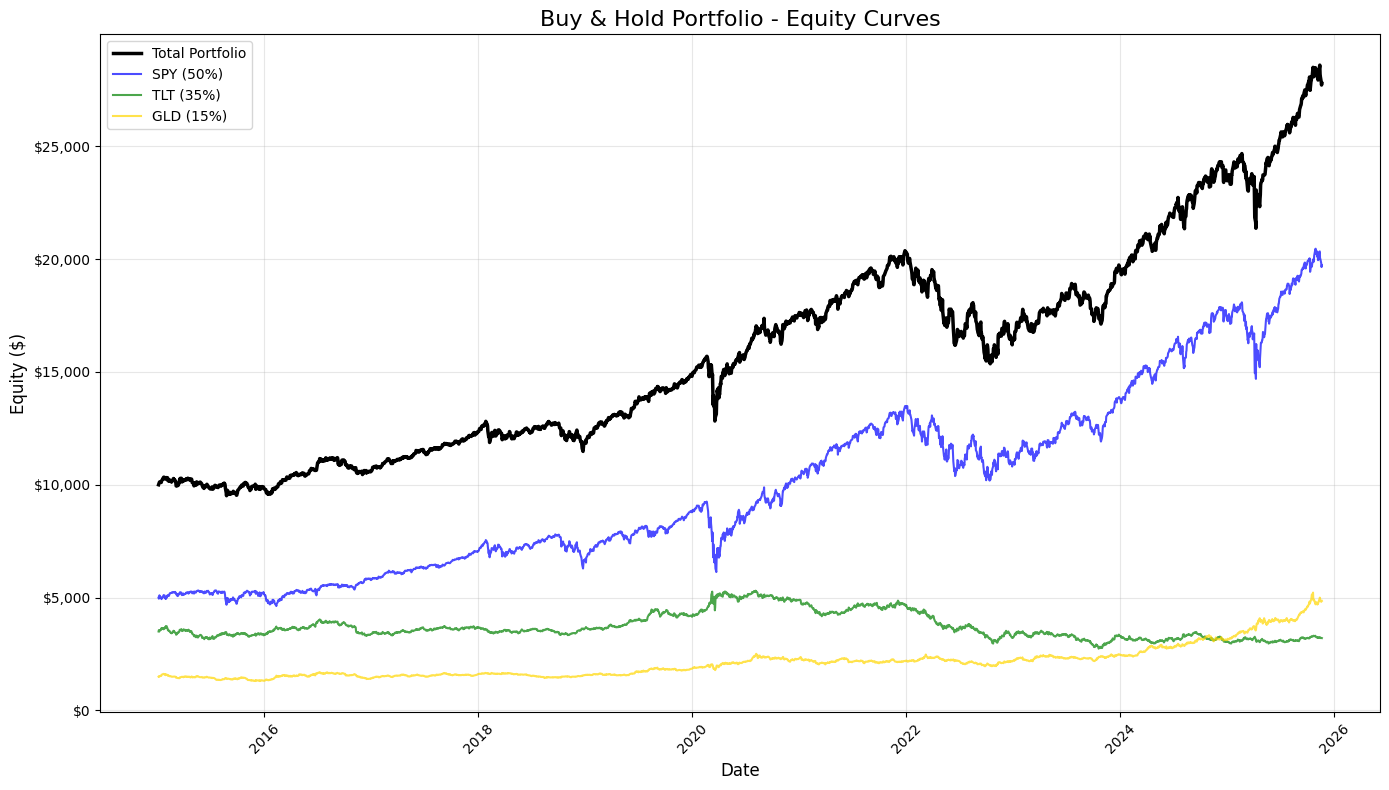

In [5]:
# 7. Static Visualizations

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot equity curves
ax.plot(equity_df.index, equity_df['total_equity'], label='Total Portfolio', linewidth=2.5, color='black')
ax.plot(equity_df.index, equity_df['SPY_equity'], label='SPY (50%)', linewidth=1.5, alpha=0.7, color='blue')
ax.plot(equity_df.index, equity_df['TLT_equity'], label='TLT (35%)', linewidth=1.5, alpha=0.7, color='green')
ax.plot(equity_df.index, equity_df['GLD_equity'], label='GLD (15%)', linewidth=1.5, alpha=0.7, color='gold')

# Formatting
ax.set_title('Buy & Hold Portfolio - Equity Curves', fontsize=16)
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Equity ($)', fontsize=12)
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)

# Format y-axis as currency
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

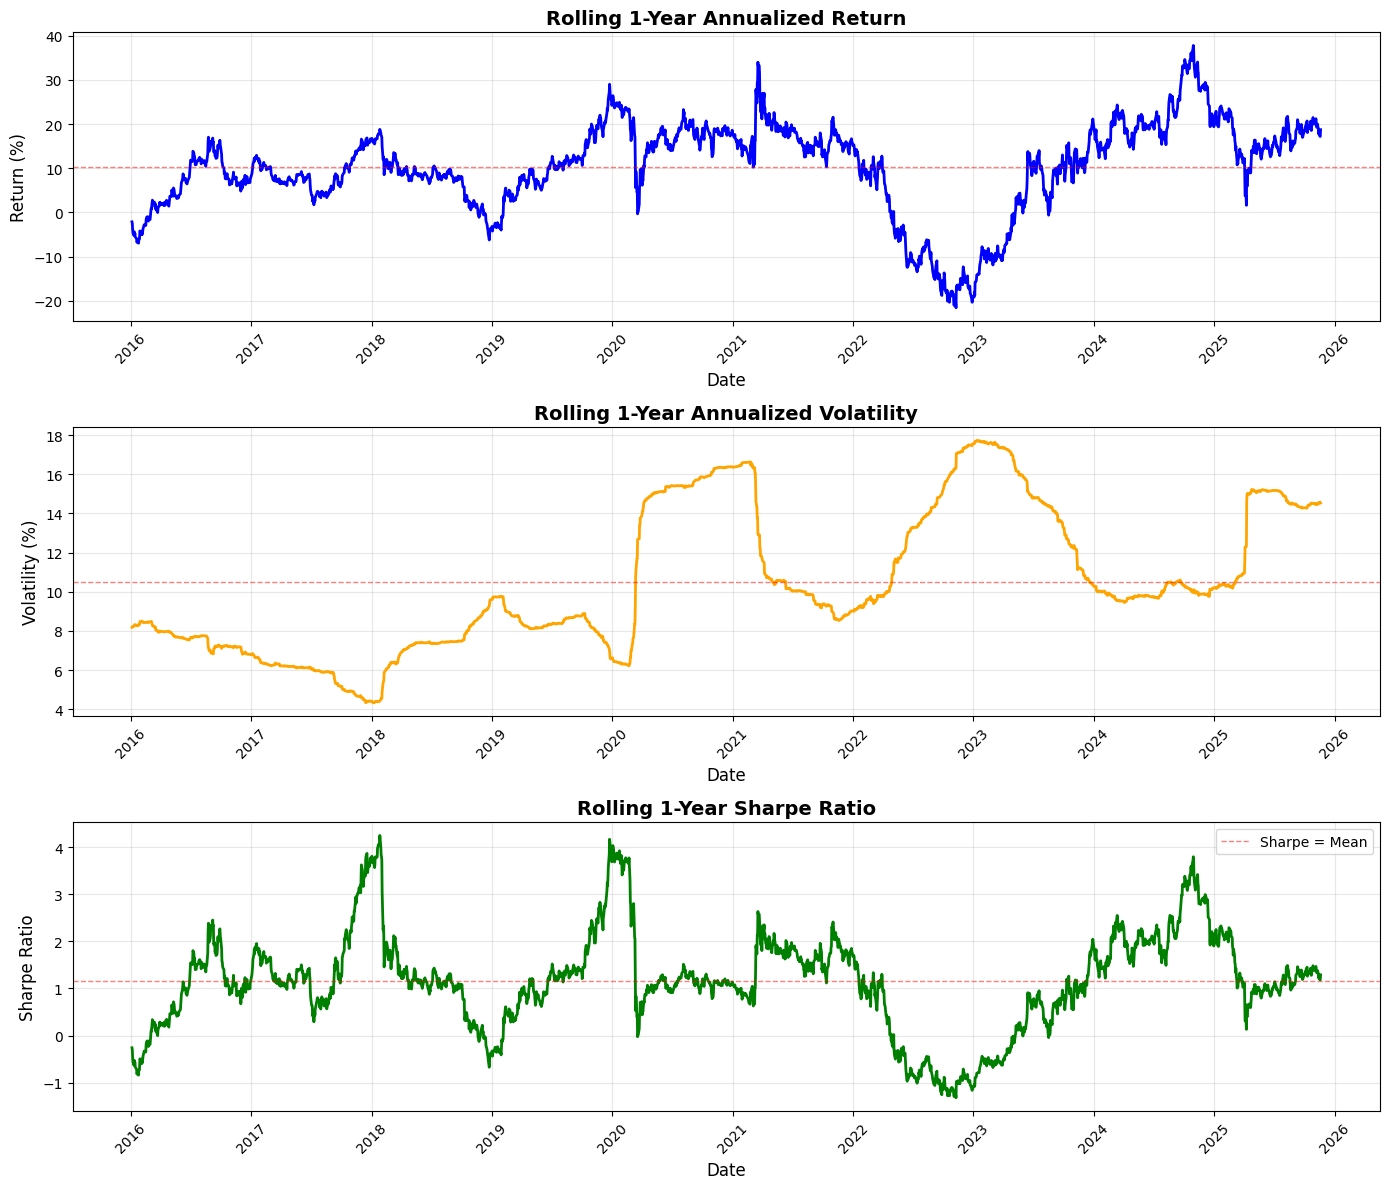


ROLLING METRICS SUMMARY (1-YEAR WINDOW)

Rolling Annualized Return:
  Mean: 10.28%
  Min:  -21.57%
  Max:  37.81%

Rolling Annualized Volatility:
  Mean: 10.50%
  Min:  4.33%
  Max:  17.72%

Rolling Sharpe Ratio:
  Mean: 1.1524
  Min:  -1.3198
  Max:  4.2471


In [11]:
# 8. Rolling Performance Analysis

# Define rolling window (252 trading days = 1 year)
window = 252

# Calculate rolling metrics
rolling_return = returns_df['portfolio_return'].rolling(window=window).apply(
    lambda x: (1 + x).prod() ** (252 / len(x)) - 1
)

rolling_volatility = returns_df['portfolio_return'].rolling(window=window).std() * np.sqrt(252)

rolling_sharpe = rolling_return / rolling_volatility

# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# 1. Rolling 1-Year Annualized Return
axes[0].plot(rolling_return.index, rolling_return * 100, linewidth=2, color='blue')
axes[0].axhline(y=rolling_return.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Return = Mean')
axes[0].set_title('Rolling 1-Year Annualized Return', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return (%)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].set_xlabel('Date', fontsize=12)

# 2. Rolling 1-Year Annualized Volatility
axes[1].plot(rolling_volatility.index, rolling_volatility * 100, linewidth=2, color='orange')
axes[1].axhline(y=rolling_volatility.mean() * 100, color='red', linestyle='--', linewidth=1, alpha=0.5, label='Volatility = Mean')
axes[1].set_title('Rolling 1-Year Annualized Volatility', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volatility (%)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].set_xlabel('Date', fontsize=12)

# 3. Rolling 1-Year Sharpe Ratio
axes[2].plot(rolling_sharpe.index, rolling_sharpe, linewidth=2, color='green')
axes[2].axhline(y=rolling_sharpe.mean(), color='red', linestyle='--', linewidth=1, alpha=0.5, label='Sharpe = Mean')
axes[2].set_title('Rolling 1-Year Sharpe Ratio', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Sharpe Ratio', fontsize=12)
axes[2].grid(True, alpha=0.3)
axes[2].set_xlabel('Date', fontsize=12)
axes[2].legend(loc='best', fontsize=10)

# Format x-axis for all subplots
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print summary statistics for rolling metrics
print("\n" + "=" * 50)
print("ROLLING METRICS SUMMARY (1-YEAR WINDOW)")
print("=" * 50)
print("\nRolling Annualized Return:")
print(f"  Mean: {rolling_return.mean():.2%}")
print(f"  Min:  {rolling_return.min():.2%}")
print(f"  Max:  {rolling_return.max():.2%}")

print("\nRolling Annualized Volatility:")
print(f"  Mean: {rolling_volatility.mean():.2%}")
print(f"  Min:  {rolling_volatility.min():.2%}")
print(f"  Max:  {rolling_volatility.max():.2%}")

print("\nRolling Sharpe Ratio:")
print(f"  Mean: {rolling_sharpe.mean():.4f}")
print(f"  Min:  {rolling_sharpe.min():.4f}")
print(f"  Max:  {rolling_sharpe.max():.4f}")
print("=" * 50)